# Neutrino interaction time reconstruction (nuvT reco)

## Goal:

The goal of this project is to develop a neural network that uses the scintillation light produced in SBND, a liquid argon TPC exposed to a neutrino beam at Fermilab. The neural network uses the number of photoelectrons observed in each of the channels in an event as input. The output estimate is the temporal coordinate of the neutrino interaction.

## Objectives: 


1- Suppress cosmics. Neutrinos should come in packets (the proton beam from which they are created sends packets of protons) while cosmics (mainly muons) have a random distribution. So if you know how to match the detector light with the trace and the interaction time you can differentiate neutrino events from noise.   
2- Search for BSM phenomena. Search between neutrino packets for packet tails that should not appear. Search if they agree with m-LLP (massive long live particles) or HNLs modeling.

## Implementation:

This program implements a CNN composed of convolutional layers (along with MaxPooling) followed by a fully connected network. The input consists of "images" with the spatial correlation of the detector map, forming four layers (separating visible and ultraviolet detectors; and both volumes).

## Import libraries:

In [2]:
import uproot
import awkward as ak
import json

import statistics as st
import collections
from random import randint
#import visualkeras
from sklearn.metrics import mean_squared_error

#typical libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

#tensorflow module
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore

#import functions.py
#from functions import detector_matrix

## Root file analysis

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

In [174]:
file_path = '/data/vidales/opana_tree_combined_v2108.root'
file = uproot.open(file_path)
print("Keys in the file:", file.classnames())

Keys in the file: {'opanatree;1': 'TDirectory', 'opanatree/OpAnaTree;1': 'TTree', 'opanatree/PDSMapTree;1': 'TTree', 'MicroBoo znoise;1': 'TH1F', 'MicroBoo unoise;1': 'TH1F', 'MicroBoo vnoise;1': 'TH1F', 'MicroBoo NoiseChan;1': 'TH1F', 'Gaussian znoise;1': 'TH1F', 'Gaussian unoise;1': 'TH1F', 'Gaussian vnoise;1': 'TH1F', 'Gaussian NoiseChan;1': 'TH1F', 'Cohnoise;1': 'TH1F', 'CohNoiseChan;1': 'TH1F'}


In [175]:
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'SimPhotonsperOpChVUV', 'SimPhotonsperOpChVIS', 'NPhotons', 'NPhotonsPMTCo', 'NPhotonsPMTUnco', 'NPhotonsPMTCoVUV', 'NPhotonsXARAPUCAVUV', 'NPhotonsXARAPUCAVIS', 'SimPhotonsLiteVUV', 'SimPhotonsLiteVIS', 'nophits', 'ophit_opch', 'ophit_peakT', 'ophit_startT', 'ophit_riseT', 'ophit_width', 'ophit_area', 'ophit_amplitude', 'ophit_pe', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_startti

 **Ha tardado 8m 30s aprox. en cargar un archivo entero de opana_tree_combined_v2108.root con aprox. 80GB**

In [176]:
# variable to be predicted
hit_nuvT = optree['nuvT'].array()
# Carga asociada a cada evento, hit, canal y tiempo
hit_PE = optree['flash_ophit_pe'].array()
# Canal asociado a cada evento, hit, carga recogida y tiempo
hit_ch = optree['flash_ophit_ch'].array()
# Tiempo asociado a cada evento, hit, canal y carga recogida
hit_t = optree['flash_ophit_time'].array()

# De momento los shifteo para no tener negativos (debería shiftearse cada subarray por separado?)
#hit_t_shifted = hit_t - ak.min(hit_t)

# Identify the indices of subarrays with exactly 2 elements
indices_to_eliminate = [i for i, subarray in enumerate(hit_nuvT) if len(subarray) == 2]

# Eliminate the subarrays with exactly 2 elements
hit_nuvT_filtered = [subarray for i, subarray in enumerate(hit_nuvT) if i not in indices_to_eliminate]
hit_PE_filtered = [subarray for i, subarray in enumerate(hit_PE) if i not in indices_to_eliminate]
hit_ch_filtered = [subarray for i, subarray in enumerate(hit_ch) if i not in indices_to_eliminate]
hit_t_filtered = [subarray for i, subarray in enumerate(hit_t) if i not in indices_to_eliminate]

In [ ]:
#ak.to_json(ak.Array(hit_nuvT_filtered), 'hit_nuvT_filtered_optreecombv2108.json')
#ak.to_json(ak.Array(hit_PE_filtered), 'hit_PE_filtered_optreecombv2108.json')
#ak.to_json(ak.Array(hit_ch_filtered), 'hit_ch_filtered_optreecombv2108.json')
#ak.to_json(ak.Array(hit_t_shifted_filtered), 'hit_t_filtered_optreecombv2108.json')

## Detector map:

The idea is to create a matrix map of the detector. We tried two techniques: 1 - realistic representation 2 - schematic representation

### 1 - Realistic representation:

In [73]:

def detector_matrix(data_dict, filter_labels, pixel):
    """
    Create a matrix from the data dictionary, filter by labels, and normalize coordinates.

    Parameters:
    - data_dict: Dictionary containing data with y, z coordinates and labels.
    - filter_labels: Set of labels to filter by.
    - pixel: Tuple (width, height) used to calculate the size of the matrix.
    
    Returns:
    - Realistic matrix of the detector
    """
    
    # Calculate size of the matrix based on pixel dimensions
    size = (math.ceil(400 / pixel[0])+1, math.ceil(500 / pixel[1]))

    # Extract y and z values and the corresponding indices from the dictionary
    y_values = [val[1] for val in data_dict.values()]
    z_values = [val[2] for val in data_dict.values()]
    labels = [val[3] for val in data_dict.values()]
    indices = list(data_dict.keys())

    # Normalize and scale the y and z data to fit into the matrix
    y_min, y_max, z_min, z_max = -200, 200, 0, 500
    y_scaled = [(y - y_min) / (y_max - y_min) * (size[0] - 1) for y in y_values]
    z_scaled = [(z - z_min) / (z_max - z_min) * (size[1] - 1) for z in z_values]

    # Rounding to the nearest integer for matrix indices
    y_indices = [min(max(round(y), 0), size[0] - 1) for y in y_scaled]  # Ensure indices are within bounds
    z_indices = [min(max(round(z), 0), size[1] - 1) for z in z_scaled]  # Ensure indices are within bounds

    # Create the matrix and initialize it with -2 for unoccupied cells
    matrix = np.full(size, -2)

    # Populate the matrix with the indices from the dictionary
    for idx, (y, z) in enumerate(zip(y_indices, z_indices)):
        if labels[idx] in filter_labels:
            matrix[y, z] = indices[idx]

    return matrix


#correccion de aprox. 
def correccion(matrix):
    row_toinsert = np.full((1, matrix.shape[1]), -2)
    column_toinsert = np.full((matrix.shape[0]+4, 1), -2)
    row_modified_matrix = np.insert(matrix, [12, 24, 32, 42], row_toinsert, axis=0)
    total_modified_matrix = np.insert(row_modified_matrix, [17,34,matrix.shape[1]], column_toinsert, axis=1)
    return total_modified_matrix

In [77]:
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
X = PDSMap['OpDetX'].array()
Y = PDSMap['OpDetY'].array()
Z = PDSMap['OpDetZ'].array()
Type = PDSMap['OpDetType'].array()

# Make dictionaries with the data
data_dict = {id_val: (x_val, y_val, z_val,int(type_val)) for id_val, x_val, y_val, z_val, type_val in zip(ID[0], X[0], Y[0], Z[0],Type[0])}
even_data_dict = {id_val: data for id_val, data in data_dict.items() if id_val % 2 == 0}
odd_data_dict = {id_val: data for id_val, data in data_dict.items() if id_val % 2 != 0}

# Define the pixel size in cm
pixel = (7.5,7.5)

# Create the detector matrices
coated_pmt_map_max = correccion(detector_matrix(even_data_dict,{0}, pixel))
uncoated_pmt_map_max = correccion(detector_matrix(even_data_dict,{1}, pixel))
xarap_vuv_map_max = correccion(detector_matrix(even_data_dict,{2}, pixel))
xarap_vis_map_max = correccion(detector_matrix(even_data_dict,{3}, pixel))
vis_map_max=correccion(detector_matrix(even_data_dict,{0,1,3}, pixel))
vuv_map_max=correccion(detector_matrix(even_data_dict,{0,2}, pixel))
total =correccion(detector_matrix(even_data_dict,{0,1,2,3}, pixel))



#plot figure to see distribution accordance to 2d map
#plt.figure(figsize=(12, 12))
#plt.imshow(total, cmap='viridis', interpolation='none')
#np.savetxt('total.csv', total, fmt='%d', delimiter=',')

# Save the matrices to a CSV file
vis_map_max = np.row_stack((vis_map_max, vis_map_max + 1))
np.savetxt('vis_map_max.csv', vis_map_max, fmt='%d', delimiter=',')
vuv_map_max = np.row_stack((vuv_map_max, vuv_map_max + 1))
np.savetxt('vuv_map_max.csv', vuv_map_max, fmt='%d', delimiter=',')


### 2 - Schematic representation:

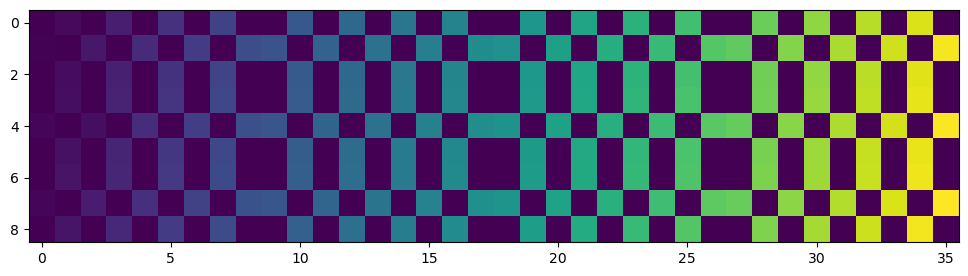

In [78]:
coated_pmt_map_min = np.array([[-2, 6, -2, -2, -2, -2, -2, 60, -2, -2, 84, -2, -2, -2, -2, -2, 138, -2, -2, 162, -2, -2, -2, -2, -2, 216, -2, -2, 240, -2, -2, -2, -2, -2, 294, -2], 
                                   [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
                                   [-2, 8, -2, -2, -2, -2, -2, 62, -2, -2, 86, -2, -2, -2, -2, -2, 140, -2, -2, 164, -2, -2, -2, -2, -2, 218, -2, -2, 242, -2, -2, -2, -2, -2, 296, -2], 
                                   [-2, 10, -2, -2, -2, -2, -2, 64, -2, -2, 88, -2, -2, -2, -2, -2, 142, -2, -2, 166, -2, -2, -2, -2, -2, 220, -2, -2, 244, -2, -2, -2, -2, -2, 298, -2], 
                                   [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
                                   [-2, 12, -2, -2, -2, -2, -2, 66, -2, -2, 90, -2, -2, -2, -2, -2, 144, -2, -2, 168, -2, -2, -2, -2, -2, 222, -2, -2, 246, -2, -2, -2, -2, -2, 300, -2], 
                                   [-2, 14, -2, -2, -2, -2, -2, 68, -2, -2, 92, -2, -2, -2, -2, -2, 146, -2, -2, 170, -2, -2, -2, -2, -2, 224, -2, -2, 248, -2, -2, -2, -2, -2, 302, -2], 
                                   [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
                                   [-2, 16, -2, -2, -2, -2, -2, 70, -2, -2, 94, -2, -2, -2, -2, -2, 148, -2, -2, 172, -2, -2, -2, -2, -2, 226, -2, -2, 250, -2, -2, -2, -2, -2, 304, -2]])

uncoated_pmt_map_min = np.array([[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
                                     [-2, -2, -2, -2, 36, -2, -2, -2, -2, -2, -2, -2, -2, 114, -2, -2, -2, -2, -2, -2, -2, -2, 192, -2, -2, -2, -2, -2, -2, -2, -2, 270, -2, -2, -2, -2], 
                                     [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
                                     [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
                                     [-2, -2, -2, -2, 38, -2, -2, -2, -2, -2, -2, -2, -2, 116, -2, -2, -2, -2, -2, -2, -2, -2, 194, -2, -2, -2, -2, -2, -2, -2, -2, 272, -2, -2, -2, -2], 
                                     [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
                                     [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
                                     [-2, -2, -2, -2, 40, -2, -2, -2, -2, -2, -2, -2, -2, 118, -2, -2, -2, -2, -2, -2, -2, -2, 196, -2, -2, -2, -2, -2, -2, -2, -2, 274, -2, -2, -2, -2], 
                                     [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]])

xarap_vuv_map_min = np.array([[-2, -2, -2, -2, -2, 42, -2, -2, -2, -2, -2, -2, -2, -2, 120, -2, -2, -2, -2, -2, -2, -2, -2, 198, -2, -2, -2, -2, -2, -2, -2, -2, 276, -2, -2, -2],
                                  [-2, -2, 18, -2, -2, -2, -2, -2, 72, -2, -2, 96, -2, -2, -2, -2, -2, 150, -2, -2, 174, -2, -2, -2, -2, -2, 228, -2, -2, 252, -2, -2, -2, -2, -2, 306], 
                                  [-2, -2, -2, -2, -2, 44, -2, -2, -2, -2, -2, -2, -2, -2, 122, -2, -2, -2, -2, -2, -2, -2, -2, 200, -2, -2, -2, -2, -2, -2, -2, -2, 278, -2, -2, -2], 
                                  [-2, -2, -2, -2, -2, 46, -2, -2, -2, -2, -2, -2, -2, -2, 124, -2, -2, -2, -2, -2, -2, -2, -2, 202, -2, -2, -2, -2, -2, -2, -2, -2, 280, -2, -2, -2], 
                                  [-2, -2, 10, -2, -2, -2, -2, -2, 74, -2, -2, 98, -2, -2, -2, -2, -2, 152, -2, -2, 176, -2, -2, -2, -2, -2, 230, -2, -2, 254, -2, -2, -2, -2, -2, 308], 
                                  [-2, -2, -2, -2, -2, 48, -2, -2, -2, -2, -2, -2, -2, -2, 126, -2, -2, -2, -2, -2, -2, -2, -2, 204, -2, -2, -2, -2, -2, -2, -2, -2, 282, -2, -2, -2], 
                                  [-2, -2, -2, -2, -2, 50, -2, -2, -2, -2, -2, -2, -2, -2, 128, -2, -2, -2, -2, -2, -2, -2, -2, 206, -2, -2, -2, -2, -2, -2, -2, -2, 284, -2, -2, -2], 
                                  [-2, -2, 22, -2, -2, -2, -2, -2, 76, -2, -2, 100, -2, -2, -2, -2, -2, 154, -2, -2, 178, -2, -2, -2, -2, -2, 232, -2, -2, 256, -2, -2, -2, -2, -2, 310], 
                                  [-2, -2, -2, -2, -2, 52, -2, -2, -2, -2, -2, -2, -2, -2, 130, -2, -2, -2, -2, -2, -2, -2, -2, 208, -2, -2, -2, -2, -2, -2, -2, -2, 286, -2, -2, -2]])

xarap_vis_map_min = np.array([[-2, -2, -2, 24, -2, -2, -2, -2, -2, -2, -2, -2, 102, -2, -2, -2, -2, -2, -2, -2, -2, 180, -2, -2, -2, -2, -2, -2, -2, -2, 258, -2, -2, -2, -2, -2], 
                                  [0, -2, -2, -2, -2, -2, 54, -2, -2, 78, -2, -2, -2, -2, -2, 132, -2, -2, 156, -2, -2, -2, -2, -2, 210, -2, -2, 234, -2, -2, -2, -2, -2, 288, -2, -2], 
                                  [-2, -2, -2, 26, -2, -2, -2, -2, -2, -2, -2, -2, 104, -2, -2, -2, -2, -2, -2, -2, -2, 182, -2, -2, -2, -2, -2, -2, -2, -2, 260, -2, -2, -2, -2, -2], 
                                  [-2, -2, -2, 28, -2, -2, -2, -2, -2, -2, -2, -2, 106, -2, -2, -2, -2, -2, -2, -2, -2, 184, -2, -2, -2, -2, -2, -2, -2, -2, 262, -2, -2, -2, -2, -2], 
                                  [2, -2, -2, -2, -2, -2, 56, -2, -2, 80, -2, -2, -2, -2, -2, 134, -2, -2, 158, -2, -2, -2, -2, -2, 212, -2, -2, 236, -2, -2, -2, -2, -2, 290, -2, -2], 
                                  [-2, -2, -2, 30, -2, -2, -2, -2, -2, -2, -2, -2, 108, -2, -2, -2, -2, -2, -2, -2, -2, 186, -2, -2, -2, -2, -2, -2, -2, -2, 264, -2, -2, -2, -2, -2], 
                                  [-2, -2, -2, 32, -2, -2, -2, -2, -2, -2, -2, -2, 110, -2, -2, -2, -2, -2, -2, -2, -2, 188, -2, -2, -2, -2, -2, -2, -2, -2, 266, -2, -2, -2, -2, -2], 
                                  [4, -2, -2, -2, -2, -2, 58, -2, -2, 82, -2, -2, -2, -2, -2, 136, -2, -2, 160, -2, -2, -2, -2, -2, 214, -2, -2, 238, -2, -2, -2, -2, -2, 292, -2, -2], 
                                  [-2, -2, -2, 34, -2, -2, -2, -2, -2, -2, -2, -2, 112, -2, -2, -2, -2, -2, -2, -2, -2, 190, -2, -2, -2, -2, -2, -2, -2, -2, 268, -2, -2, -2, -2, -2]])

vuv_map_min = np.array([[-2, 6, -2, -2, -2, 42, -2, 60, -2, -2, 84, -2, -2, -2, 120, -2, 138, -2, -2, 162, -2, -2, -2, 198, -2, 216, -2, -2, 240, -2, -2, -2, 276, -2, 294, -2], 
                        [-2, -2, 18, -2, -2, -2, -2, -2, 72, -2, -2, 96, -2, -2, -2, -2, -2, 150, -2, -2, 174, -2, -2, -2, -2, -2, 228, -2, -2, 252, -2, -2, -2, -2, -2, 306], 
                        [-2, 8, -2, -2, -2, 44, -2, 62, -2, -2, 86, -2, -2, -2, 122, -2, 140, -2, -2, 164, -2, -2, -2, 200, -2, 218, -2, -2, 242, -2, -2, -2, 278, -2, 296, -2], 
                        [-2, 10, -2, -2, -2, 46, -2, 64, -2, -2, 88, -2, -2, -2, 124, -2, 142, -2, -2, 166, -2, -2, -2, 202, -2, 220, -2, -2, 244, -2, -2, -2, 280, -2, 298, -2], 
                        [-2, -2, 10, -2, -2, -2, -2, -2, 74, -2, -2, 98, -2, -2, -2, -2, -2, 152, -2, -2, 176, -2, -2, -2, -2, -2, 230, -2, -2, 254, -2, -2, -2, -2, -2, 308], 
                        [-2, 12, -2, -2, -2, 48, -2, 66, -2, -2, 90, -2, -2, -2, 126, -2, 144, -2, -2, 168, -2, -2, -2, 204, -2, 222, -2, -2, 246, -2, -2, -2, 282, -2, 300, -2], 
                        [-2, 14, -2, -2, -2, 50, -2, 68, -2, -2, 92, -2, -2, -2, 128, -2, 146, -2, -2, 170, -2, -2, -2, 206, -2, 224, -2, -2, 248, -2, -2, -2, 284, -2, 302, -2], 
                        [-2, -2, 22, -2, -2, -2, -2, -2, 76, -2, -2, 100, -2, -2, -2, -2, -2, 154, -2, -2, 178, -2, -2, -2, -2, -2, 232, -2, -2, 256, -2, -2, -2, -2, -2, 310], 
                        [-2, 16, -2, -2, -2, 52, -2, 70, -2, -2, 94, -2, -2, -2, 130, -2, 148, -2, -2, 172, -2, -2, -2, 208, -2, 226, -2, -2, 250, -2, -2, -2, 286, -2, 304, -2]])

vis_map_min =np.array([[-2, 6, -2, 24, -2, -2, -2, 60, -2, -2, 84, -2, 102, -2, -2, -2, 138, -2, -2, 162, -2, 180, -2, -2, -2, 216, -2, -2, 240, -2, 258, -2, -2, -2, 294, -2], 
                       [0, -2, -2, -2, 36, -2, 54, -2, -2, 78, -2, -2, -2, 114, -2, 132, -2, -2, 156, -2, -2, -2, 192, -2, 210, -2, -2, 234, -2, -2, -2, 270, -2, 288, -2, -2], 
                       [-2, 8, -2, 26, -2, -2, -2, 62, -2, -2, 86, -2, 104, -2, -2, -2, 140, -2, -2, 164, -2, 182, -2, -2, -2, 218, -2, -2, 242, -2, 260, -2, -2, -2, 296, -2], 
                       [-2, 10, -2, 28, -2, -2, -2, 64, -2, -2, 88, -2, 106, -2, -2, -2, 142, -2, -2, 166, -2, 184, -2, -2, -2, 220, -2, -2, 244, -2, 262, -2, -2, -2, 298, -2], 
                       [2, -2, -2, -2, 38, -2, 56, -2, -2, 80, -2, -2, -2, 116, -2, 134, -2, -2, 158, -2, -2, -2, 194, -2, 212, -2, -2, 236, -2, -2, -2, 272, -2, 290, -2, -2], 
                       [-2, 12, -2, 30, -2, -2, -2, 66, -2, -2, 90, -2, 108, -2, -2, -2, 144, -2, -2, 168, -2, 186, -2, -2, -2, 222, -2, -2, 246, -2, 264, -2, -2, -2, 300, -2], 
                       [-2, 14, -2, 32, -2, -2, -2, 68, -2, -2, 92, -2, 110, -2, -2, -2, 146, -2, -2, 170, -2, 188, -2, -2, -2, 224, -2, -2, 248, -2, 266, -2, -2, -2, 302, -2], 
                       [4, -2, -2, -2, 40, -2, 58, -2, -2, 82, -2, -2, -2, 118, -2, 136, -2, -2, 160, -2, -2, -2, 196, -2, 214, -2, -2, 238, -2, -2, -2, 274, -2, 292, -2, -2], 
                       [-2, 16, -2, 34, -2, -2, -2, 70, -2, -2, 94, -2, 112, -2, -2, -2, 148, -2, -2, 172, -2, 190, -2, -2, -2, 226, -2, -2, 250, -2, 268, -2, -2, -2, 304, -2]])

total = coated_pmt_map_min +uncoated_pmt_map_min +xarap_vuv_map_min +xarap_vis_map_min

plt.figure(figsize=(12, 12))
plt.imshow(total, cmap='viridis', interpolation='none')

# Save the matrices to a CSV file
vis_map_min = np.row_stack((vis_map_min,vis_map_min+1))
np.savetxt('vis_map_min.csv', vis_map_min, fmt='%d', delimiter=',')
vuv_map_min = np.row_stack((vuv_map_min,vuv_map_min+1))
np.savetxt('vuv_map_min.csv', vuv_map_min, fmt='%d', delimiter=',')


**Ha tardado 129 m**

In [9]:
n_eventos = len(hit_ch)
n_canales = 312

# Creamos la matriz donde guardar el número de fotoelectrones recogidos en cada canal y por cada evento
fotoelectrones = np.zeros((n_eventos,n_canales))
tiempos = np.zeros((n_eventos,n_canales))

for i in range(n_eventos):
  max_carga_indice = np.zeros(n_canales)
  for j in range(len(hit_PE[i])):
    for k, l, t in zip(hit_PE[i][j], hit_ch[i][j], hit_t[i][j]):
      fotoelectrones[i][l] += k
      tiempos[i][l] += k*t # Ponderamos usando como pesos las cargas

**Ha tardado cinco segundos**

In [10]:
# Save the matrices to a CSV file
np.savetxt("fotoelectrones.csv", fotoelectrones, delimiter=",")
np.savetxt("tiempos.csv", tiempos, delimiter=",")

Una vez que se llegue hasta aquí no hace falta hacer lo de atrás otra vez

In [25]:
# Load the matrices from a CSV file
fotoelectrones = np.loadtxt("fotoelectrones.csv", delimiter=",")
tiempos = np.loadtxt("tiempos.csv", delimiter=",")
n_eventos = int(fotoelectrones.shape[0])
n_canales = 312

**Ha tardado tres segundos**

In [26]:
# Se normaliza con la suma total de los pesos, que es la matriz de fotoelectrones
for i in range(n_eventos):
  for j in range(n_canales):
    if fotoelectrones[i][j] != 0:
      tiempos[i][j] /= fotoelectrones[i][j]
    else:
      tiempos[i][j] = 0

### hacer mañana como función para poder meter como variable los mapas que eliga

In [29]:
ch_y = 54 # 54 pixeles en y
ch_z = 67


def image_creator(fotoelectrones,tiempos,vis_map,vuv_map,ch_y,ch_z,n_eventos):
  # Creamos la matriz con distribución espacial
  fotoelectrones_vis_map = np.zeros((n_eventos,ch_z,ch_y*2))
  fotoelectrones_vuv_map = np.zeros((n_eventos,ch_z,ch_y*2))

  tiempos_vis_map = np.zeros((n_eventos,ch_z,ch_y*2))
  tiempos_vuv_map = np.zeros((n_eventos,ch_z,ch_y*2))

  for i in range(n_eventos):
    for j in range(ch_z):
      for k in range(ch_y*2):
        if vis_map[j][k] >= 0:
          fotoelectrones_vis_map[i][j][k] = fotoelectrones[i][vis_map[j][k]]
          tiempos_vis_map[i][j][k] = tiempos[i][vis_map[j][k]]
        if vuv_map[j][k] >= 0:
          fotoelectrones_vuv_map[i][j][k] = fotoelectrones[i][vuv_map[j][k]]
          tiempos_vuv_map[i][j][k] = tiempos[i][vuv_map[j][k]]

  # Dividimos los sensores de diferente radiación en dos capas distintas y también por volúmenes
  fotoelectrones_vis_map = np.hsplit(fotoelectrones_vis_map, 2)/np.max(fotoelectrones)
  fotoelectrones_vuv_map = np.hsplit(fotoelectrones_vuv_map, 2)/np.max(fotoelectrones)

  tiempos_vis_map = np.hsplit(tiempos_vis_map, 2)/np.max(tiempos)
  tiempos_vuv_map = np.hsplit(tiempos_vuv_map, 2)/np.max(tiempos)

  image = np.zeros((np.shape(fotoelectrones_vis_map[0])[0],np.shape(fotoelectrones_vis_map[0])[1],np.shape(fotoelectrones_vis_map[0])[2],8))

  image[:,:,:,0] = fotoelectrones_vis_map[0]
  image[:,:,:,1] = fotoelectrones_vis_map[1]
  image[:,:,:,2] = fotoelectrones_vuv_map[0]
  image[:,:,:,3] = fotoelectrones_vuv_map[1]

  image[:,:,:,4] = tiempos_vis_map[0]
  image[:,:,:,5] = tiempos_vis_map[1]
  image[:,:,:,6] = tiempos_vuv_map[0]
  image[:,:,:,7] = tiempos_vuv_map[1]

  return image

# Create the images using max and min maps
image_max = image_creator(fotoelectrones,tiempos,vis_map_max,vuv_map_max,ch_y,ch_z,n_eventos)
image_min = image_creator(fotoelectrones,tiempos,vis_map_min,vuv_map_min,ch_y,ch_z,n_eventos)

print('Number of events, image height, width, layers:', np.shape(image_max))
print('Number of events, image height, width, layers:', np.shape(image_min))

IndexError: index 67 is out of bounds for axis 0 with size 67


# Visualización de los datos



¿Porque los tiempos aparecen raros?

C1: Visible/Volumen -  ||  C2: Visible/Volumen +  ||  C3: Ultravioleta/Volumen -  ||  C4: Ultravioleta/Volumen +  ||


[]

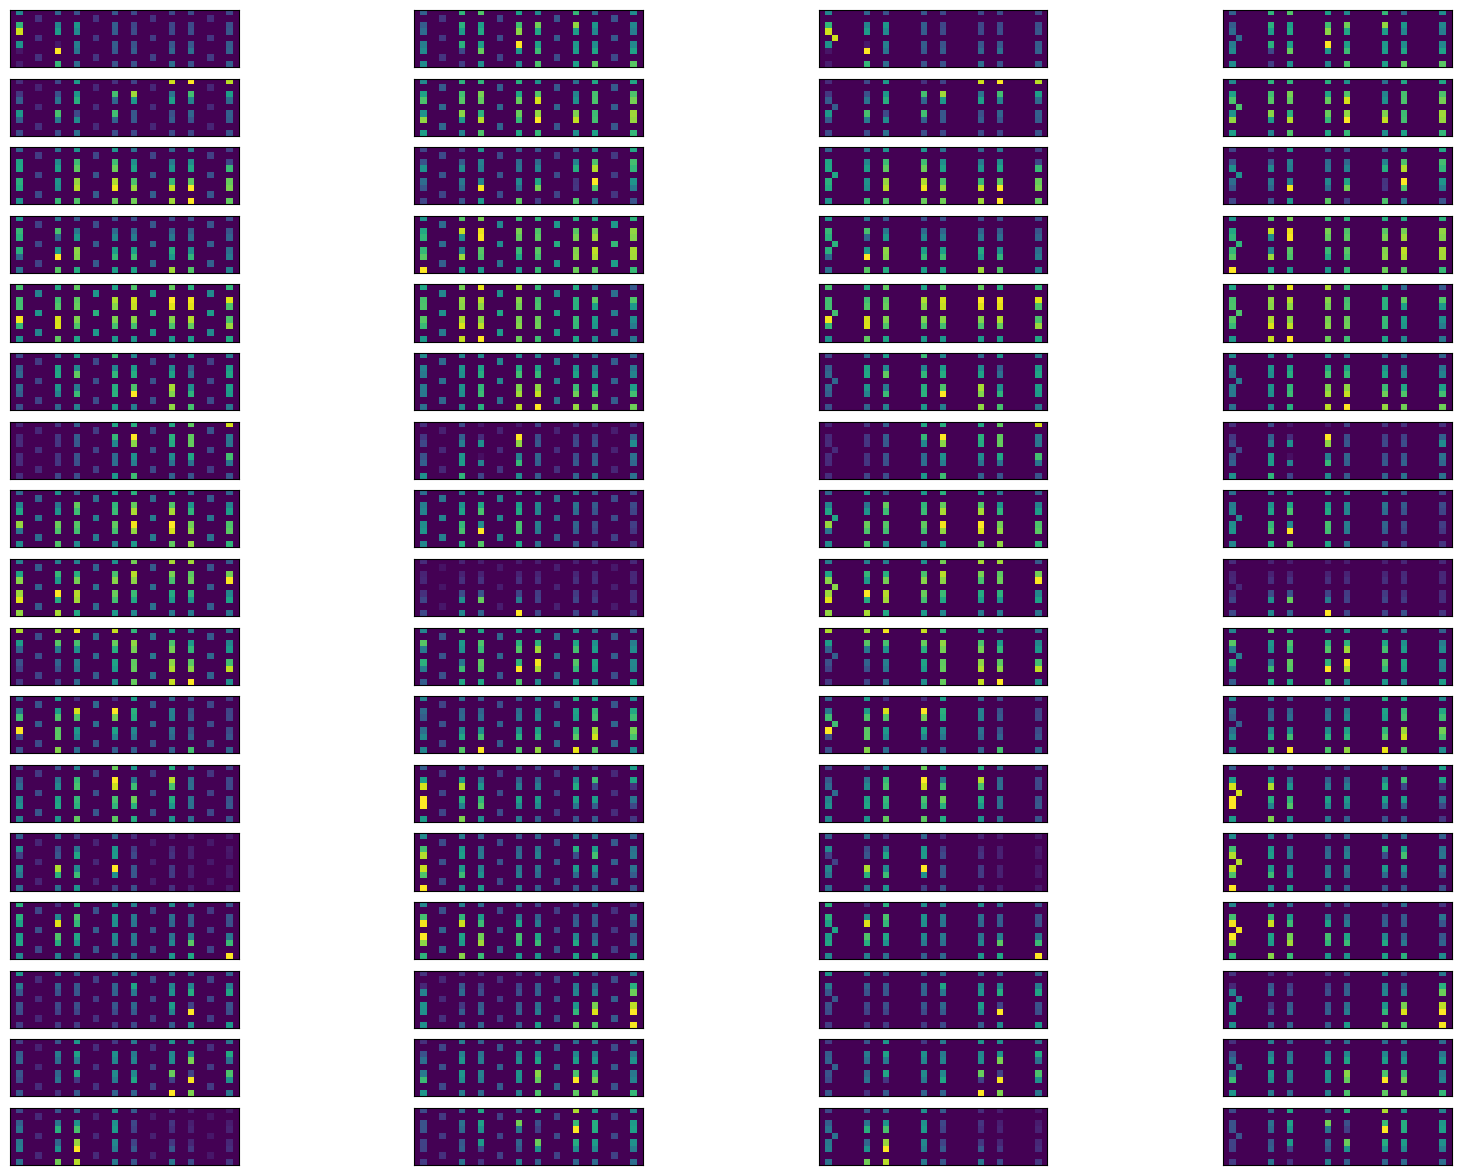

In [25]:
event_index = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

print('C1: Visible/Volumen -  ||  C2: Visible/Volumen +  ||  C3: Ultravioleta/Volumen -  ||  C4: Ultravioleta/Volumen +  ||')
#T1: Visible/Volumen -  ||  T2: Visible/Volumen +  ||  T3: Ultravioleta/Volumen -  ||  T4: Ultravioleta/Volumen +
fig, axs = plt.subplots(17, 4, figpixel=(20, 15))

for i in range(17):
  for j in range(4):
    axs[i,j].imshow(image[event_index[i],:,:,j])

plt.setp(axs, xticks=[], yticks=[])



# Reconstrucción de las coordenadas de forma individual

## Separación de los conjuntos de entrenamiento y prueba

In [26]:
hit_nuvT = optree['nuvT'].array()

#for i, subarray in enumerate(hit_nuvT):
#    print(f"Subarray {i}:", subarray)

Verificamos la dimensionalidad

In [28]:
assert np.shape(image)[0] == np.shape(hit_nuvT)[0]

ValueError: cannot convert to RegularArray because subarray lengths are not regular (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-37/awkward-cpp/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

Separamos el 60% de los datos para formar el conjunto de prueba

In [ ]:
test_size = int(np.floor(0.60*np.shape(Hit_nuvT)[0]) )
print(test_size)

In [ ]:
train_nuvTxarap, test_nuvTxarap = image[:-test_size], image[-test_size:]

train_nuvT, test_nuvT = Hit_nuvT[:-test_size], Hit_nuvT[-test_size:]

print(train_nuvTxarap.shape,test_nuvTxarap.shape)
print(len(train_nuvT),len(test_nuvT))


In [ ]:
input = layers.Input(shape=(train_nuvTxarap.shape[1], train_nuvTxarap.shape[2], train_nuvTxarap.shape[3]))

model = layers.BatchNormalization()(input)

model = layers.Conv2D(128, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D((2, 2),padding='same')(model)
model = layers.Dropout(0.3)(model)

model = layers.Conv2D(256, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
model = layers.Dropout(0.3)(model)

model = layers.Conv2D(512, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
model = layers.Dropout(0.4)(model)

model = layers.Flatten()(model)

model = layers.Dense(2048, activation='relu')(model)
model = layers.Dropout(0.2)(model)

model = layers.Dense(512, activation='relu')(model)
model = layers.Dense(128, activation='relu')(model)

output = layers.Dense(1, activation='linear')(model)

# Entrenando el modelo en la coordenada t

Se compila el modelo, incluyendo la elección del optimizador y del error que se minimizará durante el entrenamiento.

In [ ]:
# Creamos los modelos:
model_nuvT = Model(input, output)

In [ ]:
model_nuvT.summary()
model_nuvT.compile(loss='mse', optimizer='adam', metrics='mse')

In [ ]:
best_weights_file = "/tmp/weights_nuvT.hdf5"
checkpoint = ModelCheckpoint(best_weights_file, monitor='mse', verbose=0, save_best_only=True, mode='min')

# probar a modificar el batch_size (hacerlo más grande)
callbacks = [checkpoint]
history_t = model_nuvT.fit(train_nuvTxarap, train_nuvT,
                        epochs=30, batch_pixel=32, callbacks=callbacks,
                        validation_data=(test_nuvTxarap, test_nuvT),
                        verbose=2)

In [ ]:
best_weights_file = "/tmp/weights_nuvT.hdf5"
model_nuvT.load_weights(best_weights_file)
nuvT_pred = model_nuvT.predict(test_nuvTxarap)

# Visualización de resultados

Se calcula el error cuadrático medio del pronóstico.

In [ ]:
testScoreECM_nuvT = mean_squared_error(test_nuvT, nuvT_pred)
print('RECM_nuvT: %.4f' % np.sqrt((testScoreECM_nuvT)))

En la siguiente gráfica se visualiza la evolución del error para el conjunto de entrenamiento y test en función de las épocas.

In [ ]:
plt.figure(1, figsize=(8,8))
plt.plot(history_t.history['mse'])
plt.plot(history_t.history['val_mse'])

plt.yscale("log")
plt.title('Error del Modelo nuvT')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.grid()
plt.legend(['train', 'test'], loc='upper center')
plt.show()

Es importante verificar hasta donde sea posible la distribución de errores. En la siguiente gráfica se muestra el pronóstico contra los datos reales.

In [ ]:
fig, axs = plt.subplots(1,2,figpixel=(16,9))

axs[0].scatter(test_nuvT, nuvT_pred, color="black",s=5)
axs[0].grid()

axs[0].plot([0,1500],[0,1500],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,1500])
axs[0].set_ylim([0,1500])
axs[0].set_ylabel('Pronóstico [ns]')
axs[0].set_xlabel('Real [ns]')


im1 = axs[1].hist2d(test_nuvT, nuvT_pred.flatten(), bins=(100, 300), cmap='viridis',cmax=30)
fig.colorbar(im1[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,1500],[0,1500],color="r")
axs[1].set_xlim([0,1500])
axs[1].set_ylim([0,1500])
axs[1].set_ylabel('Pronóstico [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')

fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Recta_I.png', dpi=300)

Finalmente se realizan ajustes gaussianos al error entre pronóstico y datos reales para comprobar la calidad de los resultados.

In [ ]:
# Ajuste gaussiano de las diferencias entre el pronóstico y el valor real

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Variables de los histogramas
diff_nuvT = nuvT_pred.flatten()-test_nuvT

fig, axs = plt.subplots(figsize=(10,6))

# Valores de X
axs.title.set_text('nuvT')
counts_nuvT, bins_nuvT, patches_nuvT = axs.hist(diff_nuvT,120, range=[-400,400], label='Datos')

step_nuvT = (bins_nuvT[1]-bins_nuvT[0])/2
bin_centers_nuvT = bins_nuvT[:-1]+step_nuvT

ini_nuvT = 0
fin_nuvT = 119
axs.axvline(x = bin_centers_nuvT[ini_nuvT], color = 'k', label='Bordes del ajuste')
axs.axvline(x = bin_centers_nuvT[fin_nuvT], color = 'k')

popt_nuvT, pcov_nuvT = curve_fit(func, bin_centers_nuvT[ini_nuvT:fin_nuvT+1], counts_nuvT[ini_nuvT:fin_nuvT+1])


ym_nuvT = func(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), popt_nuvT[0], popt_nuvT[1], popt_nuvT[2])
axs.plot(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), ym_nuvT, c='r', label='Ajuste')
axs.set_xlabel('Bias [ns]')
axs.legend(prop = { "size": 7 })

fig.supylabel('Conteo')
fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Distrib_I.png', dpi=300)

print('------------------')
print('Media nuvT =',popt_nuvT[1])
print('Sigma nuvT =',popt_nuvT[2])
print('------------------')


In [ ]:
print('Gauss nuvT')
print(np.std(diff_nuvT))
print(np.mean(diff_nuvT))

# Data exploration

### ¿Porque hay canales que parecen que estan vacíos? ¿Porque en hit_t hay ese pico en 0 aprox.? ¿Como hacer el plot para #PE?

In [211]:
# 3 millones aprox de ophits por evento, 30 millones son como 10 eventos
def sample_awkward_arrays_in_chunks(awkward_arrays, sample_size=300000000, chunk_size=10000):
    total_size = 0
    sampled_data = []

    for array in awkward_arrays:
        # Process the array in chunks
        start = 0
        while start < len(array):
            end = min(start + chunk_size, len(array))
            chunk = array[start:end]
            
            # Flatten the chunk and convert to NumPy array if necessary
            flattened_chunk = ak.flatten(chunk)
            numpy_chunk = ak.to_numpy(flattened_chunk)
            
            # Sample from this chunk
            chunk_sample_size = min(sample_size - total_size, len(numpy_chunk))
            if chunk_sample_size > 0:
                sampled_chunk = np.random.choice(numpy_chunk, size=chunk_sample_size, replace=False)
                sampled_data.extend(sampled_chunk)
                total_size += chunk_sample_size
            
            if total_size >= sample_size:
                break
            
            start = end
        
        if total_size >= sample_size:
            break
    
    return np.array(sampled_data)

# Example usage


sampled_array = sample_awkward_arrays_in_chunks(hit_ch_filtered, sample_size=100000, chunk_size=10000)
print(sampled_array)


[223  11 295 ... 195 299 218]


In [212]:
sample_awkward_arrays_in_chunks(hit_t_filtered).shape

(300000000,)

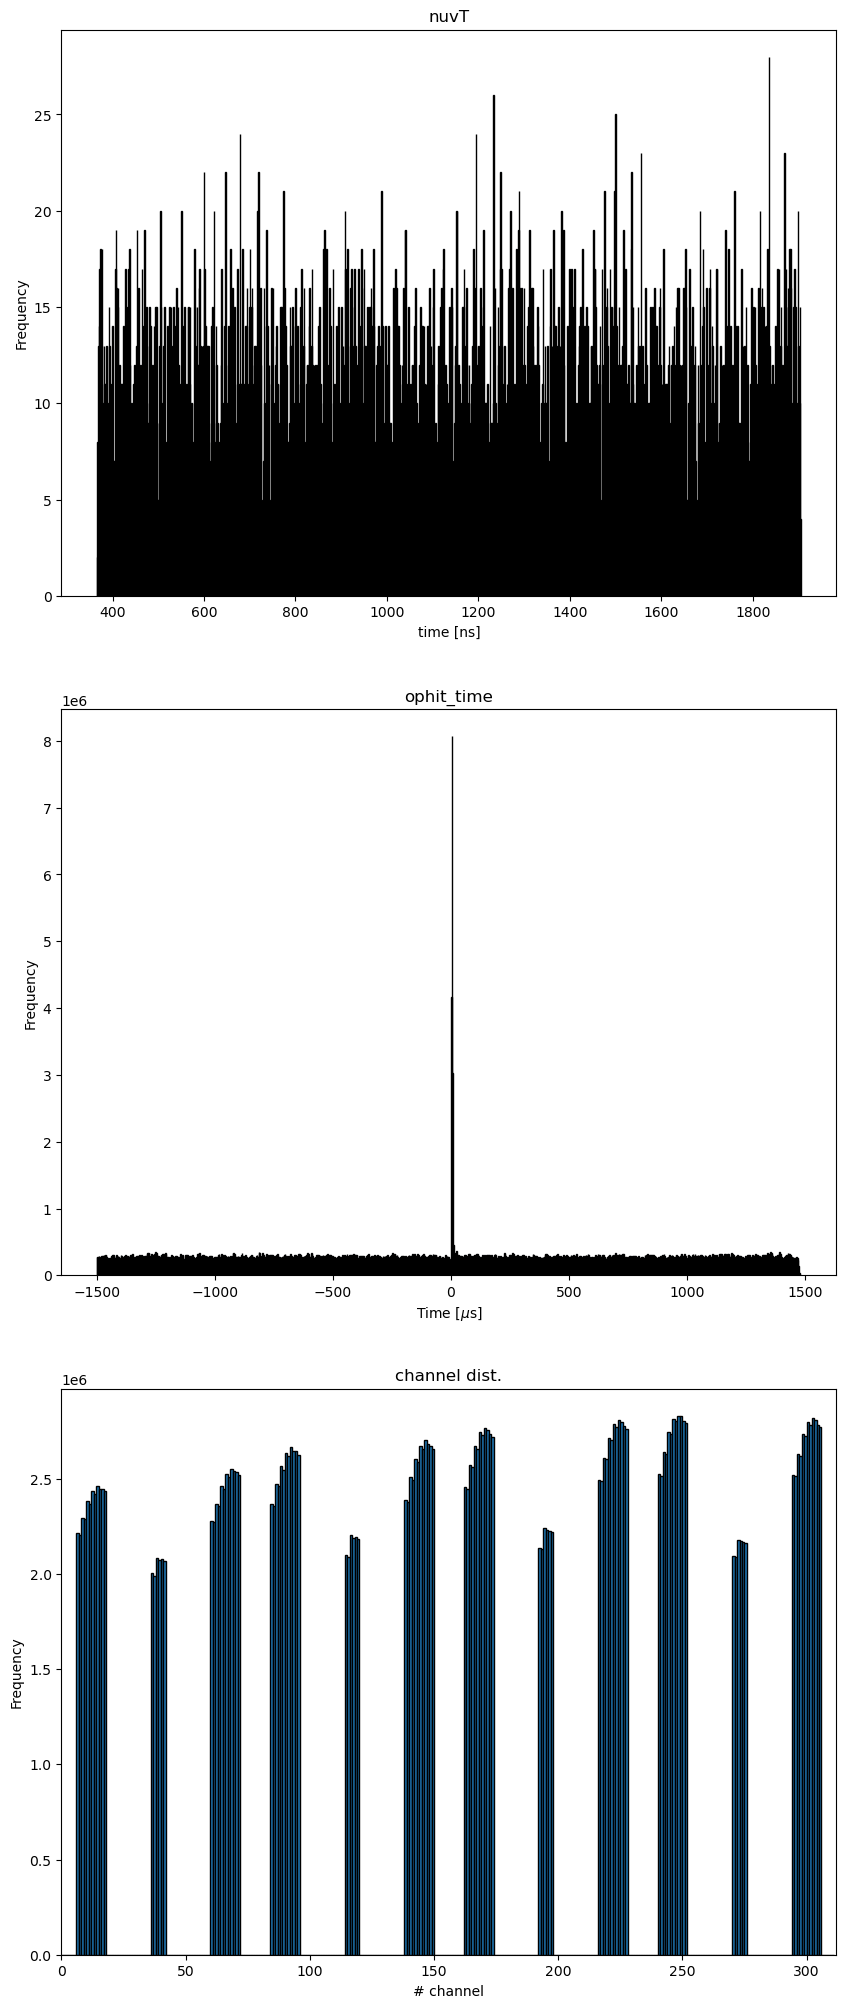

In [214]:
#Plot nuvT accumulative
flattened_hit_nuvT_filtered = ak.flatten(ak.Array(hit_nuvT_filtered))
flattened_hit_t_filtered = sample_awkward_arrays_in_chunks(hit_t_filtered)
flattened_hit_ch_filtered = sample_awkward_arrays_in_chunks(hit_ch_filtered)
fig, axs = plt.subplots(3, 1, figsize=(10, 25))

axs[0].hist(flattened_hit_nuvT_filtered, bins=1000, edgecolor='black')
axs[0].set_xlabel('time [ns]')
axs[0].set_ylabel('Frequency')
axs[0].set_title('nuvT')

axs[1].hist(flattened_hit_t_filtered, bins=1000, edgecolor='black')
axs[1].set_xlabel(r'Time [$\mu$s]')
axs[1].set_ylabel('Frequency')
axs[1].set_title('ophit_time')

axs[2].hist(flattened_hit_ch_filtered, bins=range(0, 312), edgecolor='black')
axs[2].set_xlabel('# channel')
axs[2].set_ylabel('Frequency')
axs[2].set_title('channel dist.')

# Set limits for axs[2]
axs[2].set_xlim(0, 312)  # Set x-axis limits


plt.show()

# 2D and 3D detector location map

Mapa 2D detectores

In [30]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


# Extract coordinates, color values, and IDs for even and odd 2D plots
hor_even = [coord[2] for coord in even_data_dict.values()]
ver_even = [coord[1] for coord in even_data_dict.values()]
color_even = [coord[3] for coord in even_data_dict.values()]
ids_even = [key for key in even_data_dict.keys()]

hor_odd = [coord[2] for coord in odd_data_dict.values()]
ver_odd = [coord[1] for coord in odd_data_dict.values()]
color_odd = [coord[3] for coord in odd_data_dict.values()]
ids_odd = [key for key in odd_data_dict.keys()]
# Define a custom color map with distinct colors
distinct_colors = ['rgb(255,0,0)', 'rgb(0,255,0)', 'rgb(0,0,255)', 'rgb(255,0,255)']
color_map = {i: distinct_colors[i % len(distinct_colors)] for i in range(len(set(color_even)))}
colored_text_odd = [f'<span style="color: {color_map.get(col, "black")}">{id_}</span>' for id_, col in zip(ids_odd, color_odd)]
colored_text_even = [f'<span style="color: {color_map.get(col, "black")}">{id_}</span>' for id_, col in zip(ids_even, color_even)]

# Create subplot grid
fig = make_subplots(rows=2, cols=1,subplot_titles=('Even IDs', 'Odd IDs'), vertical_spacing=0.15)

# Add 2D scatter plot for even IDs
fig.add_trace(go.Scatter(
    x=hor_even,
    y=ver_even,
    mode='text',  # Use both markers and text
    text=colored_text_even,  # Display colored IDs as text labels
    textposition='top center',  # Position text labels
    marker=dict(
        size=10,  # Marker size
        color=color_even,  # Set color based on the fourth dimension
        colorscale='Jet',  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    hoverinfo='text',  # Show text on hover
), row=1, col=1)

# Add 2D scatter plot for odd IDs
fig.add_trace(go.Scatter(
    x=hor_odd,
    y=ver_odd,
    mode='text',  # Use both markers and text
    text=colored_text_odd,  # Display colored IDs as text labels
    textposition='top center',  # Position text labels
    marker=dict(
        size=10,  # Marker size
        color=color_odd,  # Set color based on the fourth dimension
        colorscale='Jet',  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    hoverinfo='text',  # Show text on hover
), row=2, col=1)

legend_labels = ['0: CoatedPMT (VIS and VUV)', '1: UncoatedPMT (only VIS)', '2: VUV XARAPUCA', '3: VIS XARAPUCA']
for i, label in enumerate(legend_labels):
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=distinct_colors[i],  # Color for each label
            showscale=False
        ),
        name=label
    ))

# Update layout
fig.update_layout(
    title='2D Detector Planes',
    width=1200,  # Set figure width
    height=800,  # Set figure height
    xaxis=dict(
        title='Z',
    ),
    yaxis=dict(
        title='Y',
    ),
    xaxis2=dict(
        title='Z',
    ),
    yaxis2=dict(
        title='Y',
    ),
      margin=dict(l=10, r=10, t=50, b=10),
    
)

# Show the plot
fig.show()

ModuleNotFoundError: No module named 'plotly'

Mapa 3D detectores

In [ ]:
import plotly.graph_objs as go
import plotly.express as px

# Your data dictionary
data = data_dict

# Extract coordinates
x = [coord[0] for coord in data.values()]
y = [coord[1] for coord in data.values()]
z = [coord[2] for coord in data.values()]
color = [coord[3] for coord in data.values()]
ids = [key for key in data_dict.keys()]
# Create a scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=z,
    z=y,
    mode='markers',
    marker=dict(
        size=5,
        color=color,  # Set color based on the fourth dimension
        #colorscale=color_scale,  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    text=ids,  # Display point IDs on hover
    #hoverinfo='text'  # Show only the text (IDs) on hover
)])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Z',
    zaxis_title='Y'
))

fig.show()


Array of 400X500 to pixelize detector map

In [ ]:
# Function to create an array from a dictionary with fixed size
def create_map_array(data_dict, height, width):
    # Initialize the array with zeros
    map_array = np.full((height, width), -2, dtype=int)
    
    # Populate the array based on the data_dict
    for id_val, (_, y, z, _) in data_dict.items():
        # Apply the y offset to handle negative y coordinates
        y_adjusted = y + (height // 2) 
         # Shift to handle negative values
        z = int(z)  # Ensure z is an integer
        y_adjusted = int(y_adjusted)  # Ensure y_adjusted is an integer
        
        # Place the id value into the array at the correct position
        map_array[y_adjusted, z] = id_val
    
    return map_array

# Function to filter data_dict based on det_type
def filter_data_dict(data_dict, valid_types):
    return {id_val: data for id_val, data in data_dict.items() if data[3] in valid_types}

# Dimensions of the pixelized box (in cm)
fixed_height = 400
fixed_width = 500

# VIS
# Filter data_dict for valid det_types (0, 1, 3)
valid_det_types = {0, 1, 3}
filtered_even_data_dict_VIS = filter_data_dict(even_data_dict, valid_det_types)
even_map_array_VIS = create_map_array(filtered_even_data_dict_VIS, fixed_height, fixed_width)
vis_map = np.row_stack((even_map_array_VIS,even_map_array_VIS + 1))

# VUV
# Filter data_dict for valid det_types (0, 2)
valid_det_types = {0, 2}
filtered_even_data_dict_VUV = filter_data_dict(even_data_dict, valid_det_types)
even_map_array_VUV = create_map_array(even_data_dict, fixed_height, fixed_width)
vuv_map = np.row_stack((even_map_array_VUV,even_map_array_VUV + 1))

print(vis_map.shape)

np.savetxt('vis_map.txt', vis_map, fmt='%d', delimiter=',')
np.savetxt('vuv_map.txt', vis_map, fmt='%d', delimiter=',')